# 18.S096 Pset 1 Sample Solutions

The following are possible solutions to pset 1, showing some of the techniques you might apply.   Different approaches are fine too!

We're going to do a lot of quick benchmarks below, and the `@benchmark` macro returns a bit too much information.  There is a built-in `@elapsed` macro that measures elapsed time, but it is not as careful about statistics etcetera.  For convenience, let's define a `@benchtime` macro that calls `@benchmark` but returns just the minimum elapsed time:

In [1]:
using BenchmarkTools

"""
Like `@benchmark`, but returns only the minimum time in ns.
"""
macro benchtime(args...)
    b = Expr(:macrocall, Symbol("@benchmark"), map(esc, args)...)
    :(time(minimum($b)))
end

@benchtime

## Problem 1

### 1d optimized methods:

#### Speeding up the chase-the-cycles algorithm:

For comparison, let's keep the version that was supplied with the pset, but rename it to `circshift_slow!`.  This will allow us to both check correctness of our new version and also to check whether we are speeding things up.

In [2]:
function circshift_slow!(X::AbstractVector, s::Integer, B=BitVector(length(X)))
    length(B) == length(X) || throw(DimensionMismatch("wrong number of bits"))
    fill!(B, false)
    n = length(X)
    for i = 1:n
        if !B[i] # cycle starting at i has not been visited yet
            Xi = X[i]
            j = i
            while true
                k = mod(j-1-s, n) + 1
                i == k && break # done with cycle
                X[j] = X[k]
                B[j] = true
                j = k
            end
            X[j] = Xi
            B[j] = true
        end
    end
    return X
end

# write a test routine to test a `circshift!` function
# against Julia's built-in out-of-place `circshift` routine.
function test_circshift(circshift!, n::Integer)
    for s = 0:n-1
        if circshift(1:n, s) != circshift!([1:n;], s)
            error("mismatch for n=$n, s=$s for ", circshift!)
        end
    end
    println("success for n=$n with ", circshift!)
end
test_circshift(circshift!, N::AbstractVector) =
    foreach(n -> test_circshift(circshift!, n), N) 

test_circshift(circshift_slow!, [1, 7, 16, 100])

success for n=1 with circshift_slow!
success for n=7 with circshift_slow!
success for n=16 with circshift_slow!
success for n=100 with circshift_slow!


The sample solution actually isn't terrible *if* the elements of `X` are individually huge, so that `X[j] = X[k]` is very expensive and involves copying multiple cache lines by itself.  We can speed it up somewhat, though, in a few places commented on below.

In [3]:
# this is the "chase-the-cycles" algorithm supplied in the example,
# with some speedups.  (We'll take `s::Int` as a parameter,
# since our top-level `circularshift!` routine will convert
# `s::Integer` to `Int`, and we want to guard against the
# user maliciously passing a "slow" integer type like BigInt.)
function circshift_perm1!(X::AbstractVector, s::Int, B=BitVector(length(X)))
    length(B) == length(X) || throw(DimensionMismatch("wrong number of bits"))
    fill!(B, false)
    n = length(X)
    # the following two speedups are commented out
    # because we implement them in our top-level poly-algorithm,
    # below, which calls this algorithm.
    # s = mod(s, n) # speedup: reduce s mod n
    # s == 0 && return X # speedup: special case
    @assert 0 ≤ s < n
    for i = 1:n
        if !B[i] # cycle starting at i has not been visited yet
            Xi = X[i]
            j = i
            while true
                # speedup: avoid generic mod operation
                k = j - s
                if k <= 0
                    k += n
                end
                i == k && break # done with cycle
                X[j] = X[k]
                B[j] = true
                j = k
            end
            X[j] = Xi
            B[j] = true
        end
    end
    return X
end

test_circshift(circshift_perm1!, [1, 7, 16, 100])
circshift_perm1!([1,2,3,4,5], 2)

success for n=1 with circshift_perm1!
success for n=7 with circshift_perm1!
success for n=16 with circshift_perm1!
success for n=100 with circshift_perm1!


5-element Array{Int64,1}:
 4
 5
 1
 2
 3

In [4]:
@benchtime(circshift_slow!($(zeros(1000)), 102)) /
@benchtime(circshift_perm1!($(zeros(1000)), 102))

5.036069651741293

Just by avoiding the `mod` operation, we gained about a factor of 5!  Integer division is a fairly slow operation in the CPU, and we can do better than this because we know (because we took `mod(s,n)`, or rather we *will* do so below in the routine that calls this one) that `0 ≤ s < n` and hence, at most, we need to add one factor of `n` in each loop iteration.

We can do even better, however.  Let's think about the cycles of the permutation a little bit.  The length $k$ of a cycle is first number $k$ so that $ks \mod n = 0$, i.e. `ks` is the least common multiple `ks = lcm(s,n) = sn÷gcd(s,n)`, so `k=s÷gcd(s,n)` where `gcd` is the greatest common divisor.  Hence, the number of cycles is `n÷k=gcd(s,n) ≤ s`.   This leads to two immediate improvements:

* We only need our bitarray to be of length `s`, not `n`, and only need to check it for the first `s` indices.

* We can keep a count of the cycles visited and stop when we've visited them all.

* We can separate the loop iterations for indices `> s` from those `≤ s`.  The former do not need the `+ n` "wrap-around" factor, and also don't need to set the flag in the `BitVector`.

In [5]:
function circshift_perm2!(X::AbstractVector, s::Int, B=BitVector(s))
    length(B) == s || throw(DimensionMismatch("wrong number of bits"))
    fill!(B, false)
    n = length(X)
    @assert 0 ≤ s < n
    s == 0 && return X
    ncycles = gcd(s,n)
    @inbounds for i = 1:s
        if !B[i] # cycle starting at i has not been visited yet
            Xi = X[i]
            j = i
            while true
                k = j - s + n
                X[j] = X[k]
                B[j] = true
                j = k
                while j > s
                    k = j - s # j should be > s
                    X[j] = X[k]
                    j = k
                end
                j == i && break # end of cycle
            end
            k = j + s
            X[k > n ? k - n : k] = Xi
            ncycles -= 1
            ncycles == 0 && break
        end
    end
    return X
end

test_circshift(circshift_perm2!, [1, 7, 16, 100, 900])

success for n=1 with circshift_perm2!
success for n=7 with circshift_perm2!
success for n=16 with circshift_perm2!
success for n=100 with circshift_perm2!
success for n=900 with circshift_perm2!


Of course, we should check if we actually sped things up:

In [6]:
@benchtime(circshift_perm1!($(zeros(1000)), 102)) /
@benchtime(circshift_perm2!($(zeros(1000)), 102))

3.908433734939759

In [7]:
@benchtime(circshift_perm1!($(zeros(1000)), 100)) /
@benchtime(circshift_perm2!($(zeros(1000)), 100))

2.857394366197183

In [8]:
@benchtime(circshift_perm1!($(zeros(1000)), 900)) /
@benchtime(circshift_perm2!($(zeros(1000)), 900))

1.7900763358778626

Yup, it's definitely faster.

Of course, there are things we can do to make it faster still.

* If $s > n/2$, then it would be faster to apply a variant of our second algorithm that cycles in the opposite direction through the array, and uses bit flags only for the last `n-s+1` elements.  (This will increase the number of the iterations of the innermost loop relative to the outer loops.)

* We can further analyze the permutation and figure out additional tricks to identify and follow the cycles.  There is some discussion of this in the exercises of Knuth, *The Art of Computer Programming*, Vol. 1, 3rd ed., Section 1.3.3.

However, we'll stop there, because we're about to switch to an entirely different algorithm that is typically much faster.

#### Array-reversal algorithm

If the elements are sufficiently small, the cost of chasing the cycles combined with the loss of spatial locality (from jumping all around the array) is a killer.  So, we'll implement *more* methods, and pick the faster one depending on `sizeof(X[i])` and other factors.

Our second method is described in Knuth, *The Art of Computer Programming*, Vol. 1, 3rd ed., Section 1.3.3, exercise 36 (thanks to Matteo Frigo for pointing this out), and is discussed in Julia [issue #9822](https://github.com/JuliaLang/julia/pull/9822) and [issue #16032](https://github.com/JuliaLang/julia/issues/16032).

The trick is to **reverse the array**.  In particular, if we reverse the first `s` elements, reverse the last `n-s` elements, and finally reverse the whole array, we are left with the permutation that we want.  This involves two passes over the array, but each reversal pass involves **consecutive access** to the array and no complicated permutations (all the cycles have length 2 or 1).

We'll use Julia's built-in `reverse!` function for this, but it would be easy enough to write our own.

In [9]:
function circshift_reverse!(a::AbstractVector, s::Int)
    n = length(a)
    # these optimizations are implemented below
    # s = mod(s, n)
    # s == 0 && return a
    @assert 0 ≤ s < n
    s′ = n-s
    reverse!(a, 1, s′)
    reverse!(a, s′+1, n)
    reverse!(a)
end

test_circshift(circshift_reverse!, [1, 7, 16, 100, 900])

success for n=1 with circshift_reverse!
success for n=7 with circshift_reverse!
success for n=16 with circshift_reverse!
success for n=100 with circshift_reverse!
success for n=900 with circshift_reverse!


Now, let's find the crossover point between these two algorithms.  Roughly how big does each element need to be for `circshift_reverse!` to be slower than `circshift_perm2!`?

In [10]:
# make an array with n elements of elsize bytes each
make_array(n, elsize) = reinterpret(NTuple{elsize,UInt8},zeros(UInt8,n*elsize))

make_array (generic function with 1 method)

In [11]:
for elsize in 2 .^ (0:10) # size of each element, in bytes
    a = make_array(10^4, elsize)
    tp = @benchtime(circshift_perm2!($a, 253), evals=1)
    tr = @benchtime(circshift_reverse!($a, 253), evals=1)
    println("elsize $elsize ratio: ", tp/tr)
end

elsize 1 ratio: 1.05
elsize 2 ratio: 1.111969720864217
elsize 4 ratio: 2.182161883485135
elsize 8 ratio: 2.6689048760991207
elsize 16 ratio: 0.5939897654758103
elsize 32 ratio: 0.6842787949446518
elsize 64 ratio: 0.6442838291305442
elsize 128 ratio: 0.5666262593629684
elsize 256 ratio: 0.5715740313243598
elsize 512 ratio: 0.6339523322477509
elsize 1024 ratio: 0.44149789293069075


As you can see, our chase-the-cycles code does not become clearly advantageous until the element size is somewhere around 16 bytes?

Let's just be a little cautious, and make sure that the cost does not depend on the element type as well as the element size, by trying arrays of tuples of `Float64` instead of `UInt8`:

In [12]:
for elsize in 2 .^ (3:10) # size of each element, in bytes
    a = reinterpret(NTuple{elsize÷8,Float64}, make_array(10^4, elsize))
    tp = @benchtime(circshift_perm2!($a, 253), evals=1)
    tr = @benchtime(circshift_reverse!($a, 253), evals=1)
    println("Float64 elsize $elsize ratio: ", tp/tr)
end

Float64 elsize 8 ratio: 2.678520172221336
Float64 elsize 16 ratio: 1.3953013278855975
Float64 elsize 32 ratio: 0.8000430015050527
Float64 elsize 64 ratio: 0.8009781397939293
Float64 elsize 128 ratio: 0.5908567361200984
Float64 elsize 256 ratio: 0.5863674279144216
Float64 elsize 512 ratio: 0.695384654826532
Float64 elsize 1024 ratio: 0.6147575897498045


Uh oh, the speed of copying a type does depend somewhat on the type being copied.  Here, it looks like a crossover around 32 bytes is a good choice.  Basically, copying `Float64` tuples is faster than copying bytes one by one, it seems.  Probably, the compiler is sticking individual elements of the tuples in registers, and so it is more efficient if the elements of the tuple are larger (but still fit in registers).

However, even in the best case, the chase-the-cycles approach seems to be only a factor of 2 better than the reversal algorithm.

Implementing several different approaches for the same problem and picking the fastest one based on the parameters is known as a **polyalgorithm** in computer science.

#### Buffering algorithm for small `s`

As long as we're trying different algorithms, let's implement a third algorithm.  Our problem definition allowed the "in-place" algorithm to allocate a buffer 1/8 the size of `X`, so for a small shift `s` let's just copy the whole `X[1:s]` to a buffer:

In [13]:
# I would use the copy! function here, which is highly optimized, but I
# ran into a problem with views: https://github.com/JuliaLang/julia/issues/20069
function mycopy!(a, s, s′)
    @simd for i = s′:-1:1 # copy a[1:s′] to a[s+1:n]
        @inbounds a[s+i] = a[i]
    end
end
mycopy!(a::Array, s, s′) = copy!(a, s+1, a, 1, s′)

function circshift_buf1!{T}(a::AbstractVector{T}, buf::AbstractVector{T})
    n = length(a)
    s = length(buf)
    s′ = n - s
    copy!(buf, 1, a, s′+1, s) # copy a[s′+1:n] to buf[1:s]
    mycopy!(a, s, s′) # copy a[1:s′] to a[s+1:n]
    copy!(a, 1, buf, 1, s)    # copy buf to a[1:s]
    return a
end
circshift_buf1!{T}(a::AbstractVector{T}, s::Int) = circshift_buf1!(a, Array{T}(s))

test_circshift(circshift_buf1!, [1, 7, 16, 100, 900])

success for n=1 with circshift_buf1!
success for n=7 with circshift_buf1!
success for n=16 with circshift_buf1!
success for n=100 with circshift_buf1!
success for n=900 with circshift_buf1!


The idea is that this *should* be faster because involves fewer copies (`2s+n-s=n+s` copies rather than `2n`).  Let's verify this in a quick test:

In [14]:
a = rand(Int, 80000)
s = length(a)÷8
@benchtime(circshift_reverse!($a, $s)) / @benchtime(circshift_buf1!($a, $s))

1.6499427867265206

As expected, `circshift_reverse!` is a bit slower (**65% slower**).

Of course, there is another case where we can use a buffer: when `n-s` is small.  Let's implement that case, too:

In [15]:
function circshift_buf2!{T}(a::AbstractVector{T}, buf::AbstractVector{T})
    n = length(a)
    s′ = length(buf)
    s = n - s′
    copy!(buf, 1, a, 1, s′)   # copy a[1:s′] to buf
    copy!(a, 1, a, s′+1, s)   # copy a[s′+1:n] to a[1:s]
    copy!(a, s+1, buf, 1, s′) # copy buf to a[s+1:n]
    return a
end
circshift_buf2!{T}(a::AbstractVector{T}, s::Int) = circshift_buf2!(a, Array{T}(length(a)-s))

test_circshift(circshift_buf2!, [1, 7, 16, 100, 900])

success for n=1 with circshift_buf2!
success for n=7 with circshift_buf2!
success for n=16 with circshift_buf2!
success for n=100 with circshift_buf2!
success for n=900 with circshift_buf2!


Of course, if the array is sufficiently small, then the cost of allocating the buffer itself will make the buffered versions slower than the reverse version.  Let's figure out roughly where the crossover is:

In [16]:
for n in 2 .^ (0:12) # number of elements
    a = rand(n)
    s = n ÷ 8
    tr = @benchtime circshift_reverse!($a, $s)
    tb = @benchtime circshift_buf1!($a, $s)
    println("n = $n ratio: ", tr/tb)
end

n = 1 ratio: 0.45098039215686275
n = 2 ratio: 0.46153846153846156
n = 4 ratio: 0.5098039215686274
n = 8 ratio: 0.45161290322580644
n = 16 ratio: 0.5409836065573771
n = 32 ratio: 0.6612903225806451
n = 64 ratio: 0.8656716417910447
n = 128 ratio: 1.273972602739726
n = 256 ratio: 1.7708333333333333
n = 512 ratio: 2.4919354838709675
n = 1024 ratio: 3.176470588235294
n = 2048 ratio: 3.0395778364116093
n = 4096 ratio: 1.9740484429065743


So, for about 100 `Float64` elements or less, `circshift_reverse!` is faster.

#### Generated code for really small `s`

Of course, if `s` is really small, say 100 elements or less, assuming the elements themselves are small (fit in registers), we shouldn't allocate a buffer at all.  We should just stick the `s` elements into registers (via local variables, rather than allocating a buffer on the heap).

One way to implement this would be to hand-write functions `circshift_1!`, `circshift_2!`, etcetera for different values of `s`, but this is tedious.  Another way would be to use metaprogramming (lecture 4) to generate the functions for us.  A third way, demonstrated and explained by Jeff Bezanson in lecture 3, is to get Julia's compiler to generate the code for us.   Here, we use Jeff's code from that lecture:

In [17]:
function circshift_N1!{S}(X::AbstractVector, ::Val{S})
    n = length(X)
    s′ = n - S
    temp = ntuple(i->X[s′+i], Val{S})
    copy!(X, S+1, X, 1, s′)
    @inbounds for i = 1:S
        X[i] = temp[i]
    end
    return X
end
circshift_N1!(X::AbstractVector, s::Int) = circshift_N1!(X, Val{s}())

test_circshift(circshift_N1!, [1, 7, 16, 100])

success for n=1 with circshift_N1!
success for n=7 with circshift_N1!
success for n=16 with circshift_N1!
success for n=100 with circshift_N1!


As above, we'd like a second version of this as well, which handles the case where `n-s` is small:

In [18]:
function circshift_N2!{S′}(X::AbstractVector, ::Val{S′})
    n = length(X)
    s = n - S′
    temp = ntuple(i->X[i], Val{S′})
    copy!(X, 1, X, S′+1, s)
    @inbounds for i = 1:S′
        X[s+i] = temp[i]
    end
    return X
end
circshift_N2!(X::AbstractVector, s::Int) = circshift_N2!(X, Val{length(X)-s}())

test_circshift(circshift_N2!, [1, 7, 16, 100])

success for n=1 with circshift_N2!
success for n=7 with circshift_N2!
success for n=16 with circshift_N2!
success for n=100 with 

What is the crossover point at which this code-generation approach becomes better than heap-allocated buffers?

In [19]:
for s in 1:8
    a = rand(10000)
    tn = @benchtime circshift_N1!($a, $s)
    tb = @benchtime circshift_buf1!($a, $s)
    println("s = $s ratio: ", tb/tn)
end

s = 1 ratio: 0.9900990099009901
s = 2 ratio: 0.9948096885813149
s = 3 ratio: 0.9870801033591732
s = 4 ratio: 0.9891961970613656
s = 5 ratio: 0.9867123874839263
s = 6 ratio: 0.9858186506231199
s = 7 ratio: 0.9922480620155039
s = 8 ratio: 0.9887250650477016


Apparently never?  That's odd, Jeff seemed to get much better results in lecture.  Just to check, let's manually implement the `s=1` case:

In [20]:
function circshift_1!(X::AbstractVector)
    n = length(X)
    s′ = n - 1
    temp = X[n]
    copy!(X, 2, X, 1, s′)
    X[1] = temp
    return X
end

a = rand(10000)
@benchtime(circshift_buf1!($a, 1)) / @benchtime(circshift_1!($a))

1.0191451469278718

Yup, this is consistent: it's not actually any faster.   Maybe for a much smaller array the generated version is better?

In [21]:
for s in 1:8
    a = rand(100)
    tn = @benchtime circshift_N1!($a, $s)
    tb = @benchtime circshift_buf1!($a, $s)
    println("s = $s ratio: ", tb/tn)
end

s = 1 ratio: 0.7446808510638298
s = 2 ratio: 0.7555555555555555
s = 3 ratio: 0.7582417582417582
s = 4 ratio: 0.7263157894736842
s = 5 ratio: 0.6976744186046512
s = 6 ratio: 0.7802197802197802
s = 7 ratio: 0.7319587628865979
s = 8 ratio: 0.7171717171717171


Nope.  Apparently, the issue is that it spents most of the time in the `copy!` function in the middle, which is the same for both versions, and the speedup in handling the small `temp` tuple is negligible.  Whereas the `circshift_N1!` version has to do a dynamic dispatch to find the correct compiled version for that `s`, and the cost of this is enough to swamp any performance advantage. 

#### Final 1d polyalgorithm

There are other games we could play to implement faster functions, especially for various special cases, but what we have so far seems like it should be pretty good.

Let's put all of the above together into a polyalgorithm that picks which subroutine to use depending on the size of `X`, `s`, and so on:

In [22]:
function circularshift!(X::AbstractVector, s::Int)
    n = length(X)
    n == 0 && return X
    s = mod(s, n)
    s == 0 && return X
    if n <= 100
        return circshift_reverse!(X, s)
    elseif sizeof(X) ≥ 32n
        return circshift_perm2!(X, s)
    elseif 8s ≤ n
        return circshift_buf1!(X, s)
    elseif 8(n-s) ≤ n
        return circshift_buf2!(X, s)
    else
        return circshift_reverse!(X, s)
    end
end

# convert `s` to an `Int`, to prevent both type instabilities and
# bad performance if someone is perverse and passes, say, a `BigInt`.
circularshift!(X::AbstractVector, s::Integer) = circularshift!(X, Int(s))

circularshift (generic function with 1 method)

In [23]:
test_circshift(circshift_N2!, [1, 7, 16, 100])

success for n=1 with circshift_N2!
success for n=7 with circshift_N2!
success for n=16 with circshift_N2!
success for n=100 with circshift_N2!


In [24]:
# more tests:
using Base.Test
@testset "circularshift" begin
    for n in rand(1:1000, 200)
        a = rand(n)
        for s in -100:3:1100
            @test circularshift!(copy(a),s) == circshift(a,s)
        end
    end
end
println("Hooray, success!")

Test Summary: |  Pass  Total
  circularshift | 80200  80200
Hooray, success!


### 1d benchmark

Let's put it all together, and compare our `circularshift!` code to both the initial slow code and the built-in out-of-place `circshift` code.

Now, let's run a benchmark for a variety of shifts `s` for `n=10000`, to see the dependence on `s` (if any):

In [25]:
n = 10000
S = randsubseq(1:n, 0.005) # about 50 randomly chosen s values
t_slow = Array{Float64}(length(S))
t_new = Array{Float64}(length(S))
t_base = Array{Float64}(length(S))
X = rand(n)
for i = 1:length(S)
    s = S[i]
    IJulia.flush_all() # make sure output shows up right away
    t_slow[i] = @benchtime circshift_slow!($X, $s) evals=1
    t_new[i] = @benchtime circularshift!($X, $s) evals=1
    t_base[i] = @benchtime circshift($X, $s) evals=1
    println("benchmarked shift $s, $i out of ", length(S), "; time ratios = ",
            t_new[i] / t_slow[i], " and ", t_new[i] / t_base[i])
end

benchmarked shift 21, 1 out of 48; time ratios = 0.013453141488628967 and 0.415252584357324
benchmarked shift 607, 2 out of 48; time ratios = 0.016515308030140754 and 0.4668577570763167
benchmarked shift 714, 3 out of 48; time ratios = 0.016951731308085354 and 0.5749301225542894
benchmarked shift 1222, 4 out of 48; time ratios = 0.019061723373016124 and 0.5817652764306499
benchmarked shift 1522, 5 out of 48; time ratios = 0.03957370411398449 and 1.3480806766428106
benchmarked shift 1631, 6 out of 48; time ratios = 0.03966034538771714 and 1.372877618522602
benchmarked shift 1670, 7 out of 48; time ratios = 0.03932219363712779 and 1.2856547990839058
benchmarked shift 1776, 8 out of 48; time ratios = 0.039649373152583836 and 1.218719404738594
benchmarked shift 1794, 9 out of 48; time ratios = 0.039670601432832776 and 1.3122496310352099
benchmarked shift 1976, 10 out of 48; time ratios = 0.04044234814201032 and 1.2927872860635696
benchmarked shift 2181, 11 out of 48; time ratios = 0.039282

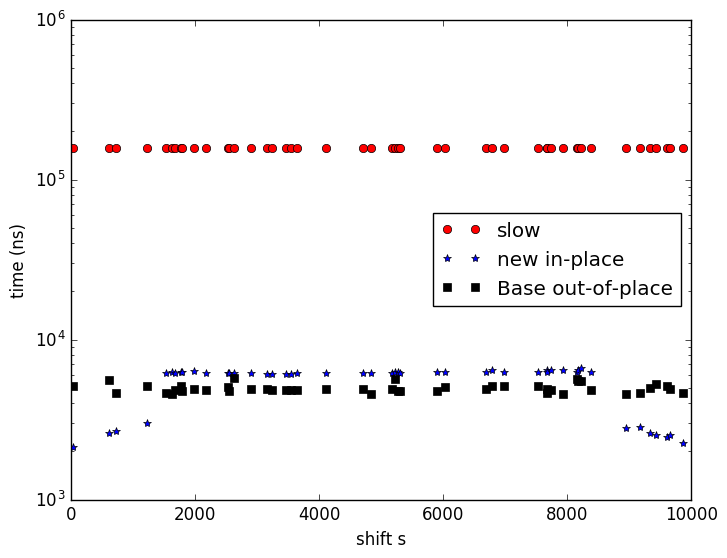

PyObject <matplotlib.legend.Legend object at 0x32847df10>

In [26]:
using PyPlot

semilogy(S, t_slow, "ro")
semilogy(S, t_new, "b*")
semilogy(S, t_base, "ks")
xlabel("shift s")
ylabel("time (ns)")
legend(["slow", "new in-place", "Base out-of-place"], loc="center right")

Note the drop-off in time at the edges where we switch to the buffered versions (since the buffers are small enough there).

We made the code over an order of magnitude faster, but the most interesting comparison is to the out-of-place code.  In general, **just because you made slow code faster doesn't mean you are fast**.  Unless you compare to other highly optimized code, you can never be sure that you are doing a good job.

### 2d optimized methods (same shift for every row):

One option is to simply do either `cirshift_reverse!` or `circshift_buf!` on every row, with the slight optimization that we allocate the buffers once per `X` rather than once per row.  (We use a `view` to manipulate a row in-place.)

In [27]:
function circshift_byrow!{T}(X::AbstractMatrix{T}, s::Int)
    n = size(X,2)
    s = mod(s, n)
    s == 0 && return X
    if 8s ≤ n
        buf1 = Array{T}(s)
        for i = 1:size(X,1)
            circshift_buf1!(view(X, i, :), buf1)
        end
    elseif 8(n-s) ≤ n
        buf2 = Array{T}(n-s)
        for i = 1:size(X,1)
            circshift_buf2!(view(X, i, :), buf2)
        end
    else
        for i = 1:size(X,1)
            circshift_reverse!(view(X, i, :), s)
        end
    end
    return X
end

circshift_byrow! (generic function with 1 method)

In [28]:
A = [1   2  3  4  5  6  7  8  9
     11 12 13 14 15 16 17 18 19]
circshift_byrow!(A, 1)

2×9 Array{Int64,2}:
  9   1   2   3   4   5   6   7   8
 19  11  12  13  14  15  16  17  18

However, recall from lecture that by Julia stores its built-in arrays (`Array`) in column-major format, i.e. with **contiguous columns**.   This means that accessing elements by row has *poor spatial locality*.  On the other hand, consider what will happen if we move *whole columns at a time* when permuting:

* Moving a whole column has excellent spatial locality if the columns are contiguous.
* Moving a whole column is so expensive that the overhead of tracking the cycles is irrelevant, so we should use the chase-the-cycles algorithm in order to move each element once rather than twice.

The only problem is that chasing the cycle with a whole column requires a buffer the size of one column in order to store the first element of the cycle, and this might exceed the allowed allocation of our "in-place" algorithm.   So, we may have to process the columns in "chunks".

In [29]:
# efficient code to copy a chunk of rows in a matrix.  (These are only called
# internally below when we can guaranteee that the indices are in-bounds.)
function _copyrows!(Xi::Vector, X::AbstractMatrix, chunkrow, i) # X[:,i] to Xi
    chunkrow -= 1
    @simd for j = 1:length(Xi)
        @inbounds Xi[j] = X[chunkrow+j, i]
    end
end
function _copyrows!(X::AbstractMatrix, chunklen, chunkrow, k, i) # X[:,i] to X[:,k]
    @simd for j = chunkrow:chunkrow+chunklen-1
        @inbounds X[j, k] = X[j, i]
    end
end
function _copyrows!(X::AbstractMatrix, chunkrow, i, Xi::Vector) # Xi to X[:,i]
    chunkrow -= 1
    @simd for j = 1:length(Xi)
        @inbounds X[chunkrow+j, i] = Xi[j]
    end
end

# like circshift_perm2! above, but permute the rows of X by s, permuting
# several rows at a time in chunks.  (It would be nicer to avoid the copy-paste
# duplication with some better abstractions here.)
function circshift_perm2!{T}(X::AbstractMatrix{T}, s::Int)
    n = size(X,2)
    n == 0 && return X
    s = mod(s, n)
    s == 0 && return X
    B = BitVector(s)
    ncycles_per_row = gcd(s,n)
    
    # figure out how big of a chunk we can allocate according to the rules
    Xi = Array{T}(1) # allocate array of 1 element to get size. 
    # We need to satisfy:
    #   chunklen*sizeof(Xi) + sizeof(B) ≤ (sizeof(Xi)*size(X,2))÷8 + 128
    chunklen = max(1, size(X,2)÷8 + (128-sizeof(B))÷sizeof(Xi))
    
    for chunkrow = 1:chunklen:size(X,1) # start of each row chunk
        # the last chunk of rows might be smaller
        chunklen = min(chunklen, size(X,1) - chunkrow + 1)
        resize!(Xi, chunklen)
        
        fill!(B, false)
        ncycles = ncycles_per_row
        @inbounds for i = 1:s
            if !B[i] # cycle starting at i has not been visited yet
                # Xi = X[i]
                _copyrows!(Xi, X, chunkrow, i)
                j = i
                while true
                    k = j - s + n
                    # X[j] = X[k]
                    _copyrows!(X, chunklen, chunkrow, j, k)
                    B[j] = true
                    j = k
                    while j > s
                        k = j - s # j should be > s
                        # X[j] = X[k]
                        _copyrows!(X, chunklen, chunkrow, j, k)
                        j = k
                    end
                    j == i && break # end of cycle
                end
                k = j + s
                # X[k > n ? k - n : k] = Xi
                _copyrows!(X, chunkrow, k > n ? k - n : k, Xi)
                ncycles -= 1
                ncycles == 0 && break
            end
        end
    end
    return X
end

circshift_perm2! (generic function with 3 methods)

Now, for fun we will try them out on some sample images as in the pset.

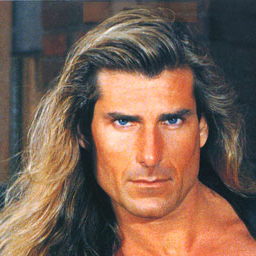

In [30]:
using Images, TestImages
img = testimage("fabio_color_256")

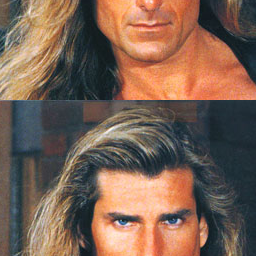

In [31]:
circshift_byrow!(copy(img), 100) # shift a copy so that we don't change the original

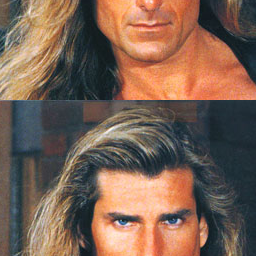

In [32]:
circshift_perm2!(copy(img), 100) # shift a copy so that we don't change the original

Let's do some more tests:

In [33]:
A = rand(90, 100)
for s in 0:89
    if circshift_byrow!(copy(A), s) != circshift_perm2!(copy(A), s)
        error("test failed for s = $s")
    end
end
println("Success!")

Success!


Finally, let's few couple of benchmarks to see how the two methods compare:

In [34]:
A = rand(300,400)
for s in (1,5,100,200,290,299)
    tr = @benchtime circshift_byrow!($(copy(A)), $s) evals=1
    tp = @benchtime circshift_perm2!($(copy(A)), $s) evals=1
    println("ratio for s=$s: ", tr/tp)
end

ratio for s=1: 1.202236478295809
ratio for s=5: 1.1729815538820814
ratio for s=100: 1.2807584777192416
ratio for s=200: 1.0392993249335163
ratio for s=290: 1.6692537013044189
ratio for s=299: 1.721777731218982


In [35]:
A = rand(150,2000)
for s in (1,5,100,200,290,299)
    tr = @benchtime circshift_byrow!($(copy(A)), $s) evals=1
    tp = @benchtime circshift_perm2!($(copy(A)), $s) evals=1
    println("ratio for s=$s: ", tr/tp)
end

ratio for s=1: 3.753252992482424
ratio for s=5: 3.7121640688211732
ratio for s=100: 3.8893947490786944
ratio for s=200: 3.6807970667941974
ratio for s=290: 6.586165886595565
ratio for s=299: 6.7194831222246965


The speed ratio varies a lot; the advantage is clearly bigger for bigger rows, where the chunk size is bigger and the improvement in spatial locality is greater.

Although in principle we could find some cases where `circshift_byrow!` is faster (especially if the `AbstractMatrix` is not a column-major `Matrix`) and make a polyalgorithm, let's call this good enough and just always use `circshift_perm2!`:

In [36]:
circularshift!(X::AbstractMatrix, s::Integer) = circshift_perm2!(X, Int(s))

circularshift! (generic function with 2 methods)

### 2d optimized methods (different shift per row):

Finally, let's implement an optimized method for the problem where each row is shifted by a different amount.  Again, let's start with a "naive" by-row algorithm for comparison:

In [37]:
function circshift_byrow!(X::AbstractMatrix)
    m, n = size(X)
    isempty(X) && return X
    s = 0
    for i = 1:m
        s += 1
        if s == n
            s = 0 # no shift
        else
            circshift_reverse!(view(X, i, :), s)
        end
    end
    return X
end

circshift_byrow! (generic function with 2 methods)

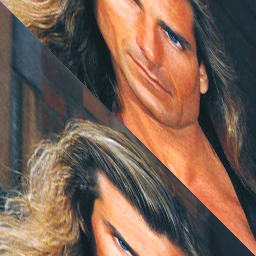

In [38]:
circshift_byrow!(copy(img))

In this case, it is a bit harder to figure out how to exploit contiguous columns, since each row is shifted by a different amount.

Although there may be more clever things to do, we'll just use the fact that, regardless of the shift `s`, the final reversal step in `circshift_reverse!` reverses the whole array.  Therefore, we can reverse all of the rows at once for the last step.

However, if we reverse *all* the rows, then we may lose some temporal locality.  If we do a "batch" of a few rows at a time, then the rows may still be in-cache when we do the final reversal.  Let's try this, with the batch size as a parameter, to figure out what the optimal batch size is:

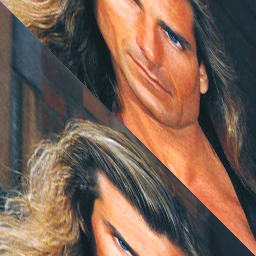

In [39]:
function circshift_bybatch!(X::AbstractMatrix, batchsize::Int)
    m, n = size(X)
    n==0 && return X # we assume n>0 below
    for i = 1:batchsize:m # i is the start of each batch
        b = min(batchsize, m-i+1) # size of the current batch
        s = mod(i, n)
        s′ = s == 0 ? 0 : n - s
        
        # perform reversals of 1:s′ and s′+1:n for each row j in the batch
        for j = i:i+b-1
            v = view(X, j, :)
            reverse!(v, 1, s′)   # reverse first s′ elements
            reverse!(v, s′+1, n) # reverse last s elements
            s′ -= 1
            if s′ < 0
                s′ += n
            end
        end
        
        # reverse the whole row for every element in the block at once:
        k = 1
        k′ = n
        @inbounds while k < k′
            @simd for j = i:i+b-1
                t = X[j, k]
                X[j, k] = X[j, k′]
                X[j, k′] = t
            end
            k  += 1
            k′ -= 1
        end
    end
    return X
end

circshift_bybatch!(copy(img), 8)

Now, let's try different batch sizes to see how it affects the time:

In [40]:
A = rand(200,400)
for b in 2.^(0:8)
    println("batch size $b time: ", @benchtime circshift_bybatch!($(copy(A)), $b) evals=1)
end

batch size 1 time: 112876.0
batch size 2 time: 93348.0
batch size 4 time: 82564.0
batch size 8 time: 76806.0
batch size 16 time: 79112.0
batch size 32 time: 79698.0
batch size 64 time: 85969.0
batch size 128 time: 86283.0
batch size 256 time: 84395.0


In [41]:
A = rand(2000,4000)
for b in 2.^(0:11)
    println("batch size $b time: ", @benchtime circshift_bybatch!($(copy(A)), $b) evals=1)
end

batch size 1 time: 1.50400087e8
batch size 2 time: 1.14193521e8
batch size 4 time: 9.8356867e7
batch size 8 time: 8.7269529e7
batch size 16 time: 8.351738e7
batch size 32 time: 8.3077466e7
batch size 64 time: 8.2515527e7
batch size 128 time: 8.7630711e7
batch size 256 time: 8.4008263e7
batch size 512 time: 8.4531269e7
batch size 1024 time: 8.3291456e7
batch size 2048 time: 8.2545448e7


In [42]:
A = rand(2000,100)
for b in 2.^(0:11)
    println("batch size $b time: ", @benchtime circshift_bybatch!($(copy(A)), $b) evals=1)
end

batch size 1 time: 381474.0
batch size 2 time: 323863.0
batch size 4 time: 280967.0
batch size 8 time: 251380.0
batch size 16 time: 249185.0
batch size 32 time: 254191.0
batch size 64 time: 269611.0
batch size 128 time: 266964.0
batch size 256 time: 267530.0
batch size 512 time: 272225.0
batch size 1024 time: 274693.0
batch size 2048 time: 269631.0


For `Float64` elements, as here, it seems like a batch size of about 32 is good, but there actually isn't much penalty to just using a batch size equal to the number of rows.  It's probably not worth optimizing this to carefully, since the precise optimum probably depends on the element size, e.g. let's do it for one-byte elements:

In [43]:
A = rand(UInt8, 2000,100)
for b in 2.^(0:11)
    println("batch size $b time: ", @benchtime circshift_bybatch!($(copy(A)), $b) evals=1)
end

batch size 1 time: 388624.0
batch size 2 time: 290750.0
batch size 4 time: 244475.0
batch size 8 time: 224920.0
batch size 16 time: 211966.0
batch size 32 time: 155916.0
batch size 64 time: 152630.0
batch size 128 time: 148848.0
batch size 256 time: 148556.0
batch size 512 time: 149453.0
batch size 1024 time: 147982.0
batch size 2048 time: 150021.0


So, let's just punt and always make the batch size equal the number of rows:

In [44]:
circularshift!(X::AbstractMatrix) = circshift_bybatch!(X, size(X,1))

circularshift! (generic function with 3 methods)

Now, let's benchmark a few sizes against the row-by-row version:

In [45]:
for (m,n) in ((200,100), (2000,100), (100,2000), (2000,1000))
    println("speedup for $m×$n: ",
        @benchtime(circshift_byrow!($(zeros(m,n))),evals=1) /
        @benchtime(circularshift!($(zeros(m,n))),evals=1))
end

speedup for 200×100: 1.1750033585598496
speedup for 2000×100: 1.2550459998013603
speedup for 100×2000: 1.6150609786182366
speedup for 2000×1000: 1.4615767823821053


The speedups are not that impressive, unfortunately.  (But it this is compared to the by-row optimized circular shift.  It should still be much faster than the by-row slow algorithm supplied with the pset.)

## Problem 2 solutions:

As above, let's save the "slow" version supplied with the pset for comparison.

In [46]:
type Sphere_slow
    center
    radius
end

makespheres_slow{T<:Real}(data::AbstractMatrix{T}) = [Sphere_slow(data[i,1:3], data[i,4]) for i = 1:size(data,1)]

Base.in(p::AbstractVector, S::Sphere_slow) = norm(p - S.center) ≤ S.radius

findsphere(S::AbstractVector{Sphere_slow}, p::AbstractVector) = findfirst(s -> p in s, S)

findsphere (generic function with 1 method)

The first thing we should do, as in lecture 1, is to use a concrete type for the fields, and an immutable type so that arrays of it are efficient:

In [47]:
immutable Sphere1{T<:Real}
    center::Vector{T}
    radius::T
end

makespheres1{T<:Real}(data::AbstractMatrix{T}) = [Sphere1(data[i,1:3], data[i,4]) for i = 1:size(data,1)]

Base.in(p::AbstractVector, S::Sphere1) = norm(p - S.center) ≤ S.radius

findsphere{T}(S::AbstractVector{Sphere1{T}}, p::AbstractVector) = findfirst(s -> p in s, S)

findsphere (generic function with 2 methods)

Now, let's generate some random spheres and benchmark it:

In [48]:
testdata = randn(1000,4) .* [100 100 100 1]
testpoints = [randn(3) * 100 for i = 1:100];

In [49]:
slow_spheres = makespheres_slow(testdata)
spheres1 = makespheres1(testdata)

# search for a bunch of points ... return the total of the indices
function benchspheres(spheres, points)
    s = 0
    for i in eachindex(points)
        s += findsphere(spheres, points[i])
    end
    return s
end

@benchtime(benchspheres($slow_spheres, $testpoints), evals=1) /
@benchtime(benchspheres($spheres1, $testpoints), evals=1)

1.2546276028800007

Meh, not even a factor of two.

However, we have a big performance trap here because our spheres use `Vector` for the `center`, which is a pointer to an array on the heap.  Furthermore, the `norm(p - S.center)` takes the difference of two `Vector`s, which allocates a new temporary vector, which imposes a huge overhead.

### A completely inlined immutable type:

One approach is to define the `x`, `y`, and `z` coordinates explicitly, and unroll the loops, but another approach is to use the [StaticArrays package](https://github.com/JuliaArrays/StaticArrays.jl), which basically does all of this for you but allows you to keep array notation.

Also, instead of `norm`, we'll use `sumabs2`, which computes `norm^2`.  This avoids a square root (and some overflow checks), and we'll compare it to the squared radius.

In [50]:
using StaticArrays

immutable Sphere2{T<:Real}
    center::SVector{3,T}
    radius2::T # the radius^2
end
Sphere2{T}(center::AbstractVector{T}, radius::T) = Sphere2{T}(SVector{3,T}(center), radius)

makespheres2{T<:Real}(data::AbstractMatrix{T}) = [Sphere2(data[i,1:3], data[i,4]^2) for i = 1:size(data,1)]

Base.in{T}(p::SVector{3,T}, S::Sphere2{T}) = sumabs2(p - S.center) ≤ S.radius2

findsphere{T}(S::AbstractVector{Sphere2{T}}, p::SVector{3,T}) = findfirst(s -> p in s, S)
findsphere{T}(S::AbstractVector{Sphere2{T}}, p::AbstractVector) = findsphere(S, SVector{3,T}(p))

findsphere (generic function with 4 methods)

In [51]:
spheres2 = makespheres2(testdata)

@benchtime(benchspheres($spheres1, $testpoints), evals=1) /
@benchtime(benchspheres($spheres2, $testpoints), evals=1)

23.954583200635756

This is more like it!  We gained another factor of 24!

### A tree data structure

However, we can still do *much* better.   The key is to realize that we don't need to search every sphere one by one.  Instead, we can store the spheres in some kind of *tree* data structure, that partitions space into halves (or more).  In this way, instead of taking $O(N)$ time to search $N$ spheres, we can actually take $O(\log N)$ time.

One such data structure is a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree), which recursively divides space in half by planes perpendicular to *one* of the coordinate axes.  However, the standard k-d tree approach searches for *points*.  To handle *spheres*, we need to modify the data structure a little bit: given a plane, each sphere can be on *both* sides of the plane.

In [52]:
# since we store the spheres in a tree, we also need to keep track of the index
# with which that sphere appeared in the original data, so that we can still return
# that index from findsphere
immutable Sphere{T<:Real}
    center::SVector{3,T}
    radius2::T # the radius^2
    index::Int # index (row) of this sphere in the original data
end
Sphere{T}(center::AbstractVector{T}, radius::T, i::Integer) = Sphere{T}(SVector{3,T}(center), radius, Int(i))

"""
A K-D tree of spheres in 3 dimensions.

This is a binary tree.  Each node in the tree divides space along
coordinate `ix` into objects that overlap the region `≤ x` and `≥ x`.
The leaves of the tree are just a list of spheres `o`.

This implementation is a little different from a standard K-D tree,
because a given object may be in both branches of the tree.  (Normally,
K-D trees are used for nearest-neighbor searches for a list of *points*,
not objects of nonzero size.)
"""
type KDTree{T<:Real}
    o::Vector{Sphere{T}}
    ix::Int # dimension being sliced (1 to 3, or 0 for leaf nodes)
    x::Float64    # the coordinate of the slice plane
    left::KDTree  # objects ≤ x in coordinate ix
    right::KDTree # objects > x in coordinate ix
    KDTree(o::Vector{Sphere{T}}) = new(o, 0)
    function KDTree(x::Real, ix::Integer, left::KDTree{T}, right::KDTree{T})
        1 ≤ ix ≤ 3 || throw(BoundsError())
        new(Sphere{T}[], ix, x, left, right)
    end
end

KDTree

In [53]:
"""
    KDTree(objects::AbstractVector{Sphere{T}})

Construct a K-D tree (`KDTree`) representation of a list `o` of
spheres in order to enable rapid searching of an object list.

When searching the tree, objects that appear earlier in `o`
take precedence over objects that appear later.
"""
function KDTree{T}(o::AbstractVector{Sphere{T}})
    length(o) <= 4 && return KDTree{T}(o)

    # figure out the best dimension ix to divide over,
    # the dividing plane x, and the number (nl,nr) of
    # objects that fall into the left and right subtrees
    ix = 0
    x = zero(T)
    nl = nr = typemax(Int)
    for i = 1:3
        mx = median(map(s -> s.center[i], o))
        mnl = count(s -> s.center[i] - sqrt(s.radius2) ≤ mx, o) # lower bound ≤ mx
        mnr = count(s -> s.center[i] + sqrt(s.radius2) > mx, o) # upper bound > mx
        if max(mnl,mnr) < max(nl,nr)
            ix = i
            x = mx
            nl = mnl
            nr = mnr
        end
    end

    # don't bother subdividing if it doesn't reduce the # of objects much
    4*min(nl,nr) > 3*length(o) && return KDTree{T}(o)

    # create the arrays of objects in each subtree
    ol = Array{Sphere{T}}(nl)
    or = Array{Sphere{T}}(nr)
    il = ir = 0
    for k in eachindex(o)
        s = o[k]
        r = sqrt(s.radius2)
        if s.center[ix] - r ≤ x
            ol[il += 1] = o[k]
        end
        if s.center[ix] + r > x
            or[ir += 1] = o[k]
        end
    end

    return KDTree{T}(x, ix, KDTree(ol), KDTree(or))
end

makespheres_{T<:Real}(data::AbstractMatrix{T}) = [Sphere(data[i,1:3], data[i,4]^2, i) for i = 1:size(data,1)]
makespheres{T<:Real}(data::AbstractMatrix{T}) = KDTree(makespheres_(data))
spheres_ = makespheres_(testdata) # simple linear array, for comparison
spheres = makespheres(testdata);

Just dumping all the data is a really unhelpful way to show the data structure, so let's define a few "pretty-printing" routines:

In [54]:
depth(kd::KDTree) = kd.ix == 0 ? 0 : max(depth(kd.left), depth(kd.right)) + 1

Base.show{T}(io::IO, kd::KDTree{T}) = print(io, "KDTree{$T} of depth ", depth(kd))

function _show(io::IO, kd::KDTree, indent)
    indentstr = " "^indent
    if kd.ix == 0
        println(io, indentstr, length(kd.o), " objects")
    else
        println(io, indentstr, "if x[", kd.ix, "] ≤ ", kd.x, ':')
        _show(io, kd.left, indent + 2)
        println(io, indentstr, "else:")
        _show(io, kd.right, indent + 2)
    end
end

function Base.show(io::IO, ::MIME"text/plain", kd::KDTree)
    println(io, kd, ':')
    _show(io, kd, 0)
end

spheres

KDTree{Float64} of depth 9:
if x[1] ≤ 2.2445375924138307:
  if x[2] ≤ -5.241187485130636:
    if x[1] ≤ -63.906532065856766:
      if x[2] ≤ -73.3063614024798:
        if x[1] ≤ -103.40547670446426:
          if x[1] ≤ -153.9930154047239:
            if x[2] ≤ -150.66017209687436:
              if x[1] ≤ -195.37279525869883:
                4 objects
              else:
                4 objects
            else:
              if x[1] ≤ -204.27548391105142:
                4 objects
              else:
                4 objects
          else:
            if x[1] ≤ -120.4806318693748:
              if x[3] ≤ -3.712122347647863:
                4 objects
              else:
                4 objects
            else:
              if x[1] ≤ -112.04902567395438:
                4 objects
              else:
                4 objects
        else:
          if x[2] ≤ -117.62663877656077:
            if x[1] ≤ -77.93973100234398:
              if x[2] ≤ -130.82828778328383:
               

Now, let's write the function to find a `Sphere` in an array or a tree:

In [55]:
Base.in{T}(p::SVector{3}, S::Sphere{T}) = sumabs2(p - S.center) ≤ S.radius2

function findsphere{T}(o::AbstractVector{Sphere{T}}, p::SVector{3})
    for i in eachindex(o)
        if p in o[i]
            return o[i].index
        end
    end
    return 0
end

function findsphere{T}(kd::KDTree{T}, p::SVector{3})
    if isempty(kd.o)
        if p[kd.ix] ≤ kd.x
            return findsphere(kd.left, p)
        else
            return findsphere(kd.right, p)
        end
    else
        return findsphere(kd.o, p)
    end
end

findsphere{T}(S::AbstractVector{Sphere{T}}, p::AbstractVector) = findsphere(S, SVector{3}(p))
findsphere{T}(kd::KDTree{T}, p::AbstractVector) = findsphere(kd, SVector{3}(p))

findsphere (generic function with 8 methods)

Now, let's test this machinery by checking that naive linear search matches the fancy tree search:

In [56]:
for p in testpoints
    if findsphere(spheres, p) != findsphere(spheres_, p)
        error("found wrong sphere for point $p")
    end
end
println("Success!")

Success!


Finally, let's benchmark it:

In [57]:
@benchtime(benchspheres($spheres2, $testpoints), evals=1) /
@benchtime(benchspheres($spheres, $testpoints), evals=1)

10.257748328193227

Yay, we got another factor of 10.  So, the overall improvement is:

In [58]:
@benchtime(benchspheres($slow_spheres, $testpoints), evals=1) /
@benchtime(benchspheres($spheres, $testpoints), evals=1)

308.6639092485022

A factor of 300 is pretty good!  Presumably, it should be even better if we have more spheres, so that we get even more benefit from the tree data structure:

In [59]:
testdata_big = randn(10000,4) .* [100 100 100 0.1]
slow_spheres_big = makespheres_slow(testdata_big)
spheres_big = makespheres(testdata_big)

@benchtime(benchspheres($slow_spheres_big, $testpoints), evals=1) /
@benchtime(benchspheres($spheres_big, $testpoints), evals=1)

2376.182097186701

Yup, a factor of 2000 improvement!  The sky is the limit when you go from $O(N)$ to $O(\log N)$.

We should also check that we aren't messing up performance when the number of spheres is *small*:

In [60]:
testdata_small = randn(20,4) .* [100 100 100 0.1]
spheres2_small = makespheres(testdata_small)
spheres_small = makespheres(testdata_small)

@benchtime(benchspheres($spheres2_small, $testpoints)) /
@benchtime(benchspheres($spheres_small, $testpoints))

1.0069451334457784

Pretty good!  About the same time as linear search for such a small list of 20 spheres.